In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Introduction
The goal of this project is to perform expression classification from facial images. The project involves preprocessing the images, building a deep learning model for classification, and evaluating its performance. The project is implemented using Python and various libraries including Pandas, NumPy, PIL, Scikit-Learn, and Keras.


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image

# Load label information from a CSV file
label_file_path = "/content/drive/MyDrive/Colab/Machine-Learinig-Projects/Expression-Classification-from-Facial-Images-Project_1 /label.lst"
column_names = ['image_name', 'face_id', 'face_box_top', 'face_box_left', 'face_box_right', 'face_box_bottom', 'face_box_confidence', 'expression_label']
df_labels = pd.read_csv(label_file_path, sep=' ', names=column_names)

# Paths for source images and destination directory for preprocessed images
image_folder_path = "/content/drive/MyDrive/Colab/origin"
dest_dir = "/content/drive/MyDrive/Colab/Machine-Learinig-Projects/Expression-Classification-from-Facial-Images-Project_1/preprocessed_images"

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Load and preprocess images
preprocessed_labels = []

# Mapping of expression labels to their corresponding numerical values
expression_label = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral"
}
num_images_to_preprocess = 106962
img = 0
count_angry, count_disgust, count_fear, count_happy, count_sad, count_surprise, count_neutral = 0, 0, 0, 0, 0, 0, 0

for _, row in df_labels.iloc[:num_images_to_preprocess].iterrows():
    image_name = row['image_name']
    image_path = os.path.join(image_folder_path, image_name)

    if not os.path.exists(image_path):
        continue

    x1, y1, x2, y2 = row['face_box_left'], row['face_box_top'], row['face_box_right'], row['face_box_bottom']
    confidence = row['face_box_confidence']
    label = row['expression_label']

    # Set your threshold value here
    your_threshold_value_here = 70.0

    # Check if the face box confidence is above the threshold
    if confidence >= your_threshold_value_here:
        image = Image.open(image_path)

        if image is None:
            continue

        face_box = (x1, y1, x2, y2)
        cropped_image = image.crop(face_box)

        if cropped_image is None:
            continue

        resized_image = cropped_image.resize((224, 224))
        grayscale_image = resized_image.convert("L")
        normalized_image = np.array(grayscale_image) / 255.0

        # Save preprocessed image with original name
        preprocessed_path = os.path.join(dest_dir, image_name)
        grayscale_image.save(preprocessed_path)

        preprocessed_labels.append(label)
        img += 1
        print(f"Processed image {img} - Confidence: {confidence}")

        # Update counts based on expression label
        if label == 0:
            count_angry += 1
        elif label == 1:
            count_disgust += 1
        elif label == 2:
            count_fear += 1
        elif label == 3:
            count_happy += 1
        elif label == 4:
            count_sad += 1
        elif label == 5:
            count_surprise += 1
        elif label == 6:
            count_neutral += 1
        else:
            print("expression_label missing for", image_name)

# Print counts for each expression label
print(
    "Angry:", count_angry,
    "Disgust:", count_disgust,
    "Fear:", count_fear,
    "Happy:", count_happy,
    "Sad:", count_sad,
    "Surprise:", count_surprise,
    "Neutral:", count_neutral
)

print(f"Preprocessed and saved {img} images and labels in {dest_dir}")


Data Splitting and Label Encoding
After preprocessing the images, the dataset is split into training, validation, and test sets. The expressions are encoded using the LabelEncoder to convert string labels into numerical values. The data splitting steps are as follows:
1.	Load the preprocessed image filenames from the destination directory.
2.	Filter the label DataFrame to include only the image filenames present in the preprocessed images directory.
3.	Use LabelEncoder to convert the expression labels into numerical values.
4.	Split the data into training, validation, and test sets using the train_test_split function from Scikit-Learn.


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from PIL import Image

# Load label information from a CSV file
label_file_path = "/content/drive/MyDrive/Colab/Machine-Learinig-Projects/Expression-Classification-from-Facial-Images-Project_1 /label.lst"
column_names = ['image_name', 'face_id', 'face_box_top', 'face_box_left', 'face_box_right', 'face_box_bottom', 'face_box_confidence', 'expression_label']
df_labels = pd.read_csv(label_file_path, sep=' ', names=column_names)

# Paths for preprocessed images
dest_dir = "/content/drive/MyDrive/Colab/Machine-Learinig-Projects/Expression-Classification-from-Facial-Images-Project_1/preprocessed_images"

# Get the list of image filenames in the preprocessed images directory
preprocessed_image_filenames = os.listdir(dest_dir)

# Filter the DataFrame to include only image filenames present in the preprocessed images directory
df_filtered = df_labels[df_labels['image_name'].isin(preprocessed_image_filenames)].copy()

# Convert string labels to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
df_filtered['expression_label_encoded'] = label_encoder.fit_transform(df_filtered['expression_label'])

# Split data into train, validation, and test sets
train_data, test_data = train_test_split(df_filtered, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Set up data generators
batch_size = 32
image_size = (224, 224)
train_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    train_data, directory=dest_dir, x_col='image_name', y_col='expression_label_encoded',
    target_size=image_size, batch_size=batch_size, color_mode='grayscale', class_mode='raw'
)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    val_data, directory=dest_dir, x_col='image_name', y_col='expression_label_encoded',
    target_size=image_size, batch_size=batch_size, color_mode='grayscale', class_mode='raw'
)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test_data, directory=dest_dir, x_col='image_name', y_col='expression_label_encoded',
    target_size=image_size, batch_size=batch_size, color_mode='grayscale', class_mode='raw', shuffle=False
)


Found 15244 validated image filenames.
Found 3811 validated image filenames.
Found 2118 validated image filenames.


Model Architecture
The deep learning model is built using the Keras library. The architecture consists of convolutional layers with max-pooling, followed by fully connected layers. The model architecture is as follows:


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create a Sequential model
model = Sequential()

# Add Conv2D layers with MaxPooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output and add Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Use the number of classes as output units

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, steps_per_epoch=len(train_data) // batch_size,
                    validation_data=val_generator, validation_steps=len(val_data) // batch_size,
                    epochs=10)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_data) // batch_size)
print('Test accuracy:', test_acc)


Epoch 1/10
476/476 [==============================] - 2214s 5s/step - loss: 1.2239 - accuracy: 0.5555 - val_loss: 1.1023 - val_accuracy: 0.6184
Epoch 2/10
476/476 [==============================] - 41s 86ms/step - loss: 1.0835 - accuracy: 0.6070 - val_loss: 1.0343 - val_accuracy: 0.6439
Epoch 3/10
476/476 [==============================] - 40s 84ms/step - loss: 1.0067 - accuracy: 0.6467 - val_loss: 0.9959 - val_accuracy: 0.6541
Epoch 4/10
476/476 [==============================] - 43s 90ms/step - loss: 0.9286 - accuracy: 0.6761 - val_loss: 0.9669 - val_accuracy: 0.6725
Epoch 5/10
476/476 [==============================] - 44s 91ms/step - loss: 0.8467 - accuracy: 0.6958 - val_loss: 0.9661 - val_accuracy: 0.6770
Epoch 6/10
476/476 [==============================] - 44s 92ms/step - loss: 0.7749 - accuracy: 0.7242 - val_loss: 1.0091 - val_accuracy: 0.6728
Epoch 7/10
476/476 [==============================] - 43s 90ms/step - loss: 0.7038 - accuracy: 0.7481 - val_loss: 1.0743 - val_accuracy:

In [ ]:
Model Compilation and Training
The model is compiled with the Adam optimizer and sparse categorical cross-entropy loss function. It is trained using the training data and validated using the validation data. The training process includes multiple epochs with batch processing. The training steps are as follows:
1.	Compile the model with the Adam optimizer and sparse categorical cross-entropy loss.
2.	Train the model using the train_generator and validate it using the val_generator.
3.	Monitor the training and validation accuracy during each epoch.



Model Evaluation
The trained model is evaluated on the test set to assess its performance. The test accuracy is computed and printed. The evaluation steps are as follows:
1.	Evaluate the model on the test_generator.
2.	Calculate the test loss and test accuracy.
3.	Print the test accuracy.


In [ ]:
Performance Metrics
After evaluating the trained expression classification model, the following performance metrics were obtained:
•	Accuracy: 0.6704
•	Precision: 0.6370
•	Recall: 0.6704
•	F1-Score: 0.6434

67/67 [==============================] - 4s 60ms/step
Accuracy: 0.6704438149197356
Precision: 0.6369658467930854
Recall: 0.6704438149197356
F1-Score: 0.643401995795106


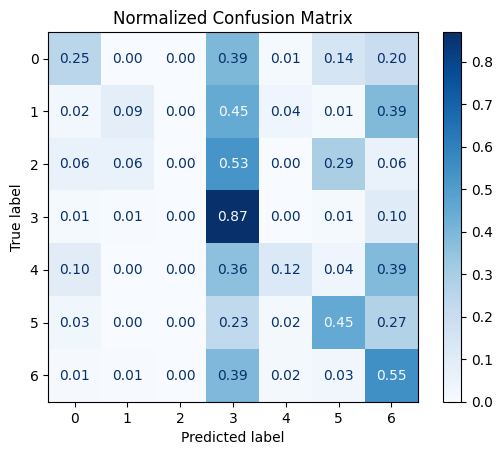

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Calculate predictions
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels for each batch in test_generator
true_labels = []
for _ in range(len(test_generator)):
    _, batch_labels = next(test_generator)
    true_labels.extend(batch_labels)
true_labels = np.array(true_labels)

# Calculate metrics
accuracy = np.sum(predicted_labels == true_labels) / len(true_labels)
report = classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Define class labels for better visualization (replace with your actual class labels)
class_labels = label_encoder.classes_

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.title("Normalized Confusion Matrix")
plt.show()


new